## <center><ins>Trabajo Práctico 1: Reservas de hotel</ins></center>
#### <center>*Checkpoint 3: Ensambles - XGBoost*</center>
##### <center>75.06 / 95.58 Organización de Datos - FIUBA</center>
##### <center>Ing. Rodríguez - 1°C 2023</center>
---
#### <center>**Grupo 31 - "Datazo":**</center>
<center> Michael Mena - 102685</center>
<center>Pablo Brocca - 104256</center>
<center>Diego Kisinovsky - 106203</center>

---
---

## Carga de datos y librerías

##### Imports:

In [1]:
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import dtreeviz.trees as dtreeviz
import pydotplus
from IPython.display import Image

# Modelos y métricas
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import DistanceMetric
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz, plot_tree
from six import StringIO
import xgboost as xgb

# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler

# Manejo de modelos
from pickle import dump
from pickle import load

# Configuración de warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

##### Lectura del dataset preprocesado:

In [2]:
hotel_train = pd.read_csv('./dataset/hotels_train_preprocesado.csv')

---

## Armado y entrenamiento del modelo

##### Preparación de features:

In [3]:
features = hotel_train.drop(['is_canceled'],axis=1).columns
          
target = 'is_canceled'

features.tolist()

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'stays_in_nights',
 'total_of_guests',
 'room_type_unchanged',
 'country_encoded',
 'customer_type_Group',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'hotel_Resort Hotel',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_TA/TO',
 'distribution_channel_Undefined',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'market_segment_Undefined',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined']

##### Train-Test Split:

In [4]:
# Separamos un 20% de los datos para test
x_train, x_test, y_train, y_test = train_test_split(hotel_train[features].values, 
                                                    hotel_train[target].values, 
                                                    test_size=0.2,    
                                                    random_state=42,  
                                                    stratify=hotel_train[target].values) 

# Verificamos cantidad de datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

# Verificamos como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48682
# Datos Prueba: 12171
% Positivos Entrenamiento: 50.433
% Positivos Prueba: 50.431


##### XGBoost:

In [5]:
#Cantidad de combinaciones
n = 20

#Grilla de Parámetros
params_grid = {'n_estimators': list(range(100, 501, 10)),
               'learning_rate': [0.05,0.10,0.15,0.20],
               'max_depth': list(range(1,16)),
               'min_child_weight': [ 1, 3, 5, 7, 10, 100 ],
               'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
               'colsample_bytree': [ 0.3, 0.4, 0.5 , 0.7 ]}

# Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=10)

# XGBoost
base_xgb = xgb.XGBClassifier()

# Elegimos la metrica a utilizar
scorer_fn = make_scorer(sk.metrics.f1_score)

# Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_xgb,
                              param_distributions=params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

randomcv.fit(x_train, y_train)
randomcv.cv_results_['mean_test_score']

array([0.87041471, 0.88486353, 0.86663305, 0.87177605, 0.86126703,
       0.88151136, 0.88455375, 0.88562192, 0.87826302, 0.88014266,
       0.8754241 , 0.86220884, 0.88378368, 0.8831715 , 0.84270799,
       0.87742989, 0.8336928 , 0.88402767, 0.88268959, 0.88262301])

In [6]:
print('Mejores parámetros: ', randomcv.best_params_)
print('Mejor score: ', randomcv.best_score_)

Mejores parámetros:  {'n_estimators': 170, 'min_child_weight': 1, 'max_depth': 13, 'learning_rate': 0.05, 'gamma': 0.0, 'colsample_bytree': 0.4}
Mejor score:  0.8856219233779432


In [7]:
# Cada valor representa F1 score, la cantidad varia por el parametro n
randomcv.cv_results_['mean_test_score']

array([0.87041471, 0.88486353, 0.86663305, 0.87177605, 0.86126703,
       0.88151136, 0.88455375, 0.88562192, 0.87826302, 0.88014266,
       0.8754241 , 0.86220884, 0.88378368, 0.8831715 , 0.84270799,
       0.87742989, 0.8336928 , 0.88402767, 0.88268959, 0.88262301])

In [8]:
model_xgb = randomcv.best_estimator_

---

## Análisis del modelo XGBoost

#### Reporte de clasificación y matriz de confusión:

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      6033
           1       0.88      0.88      0.88      6138

    accuracy                           0.88     12171
   macro avg       0.88      0.88      0.88     12171
weighted avg       0.88      0.88      0.88     12171



Text(50.722222222222214, 0.5, 'True')

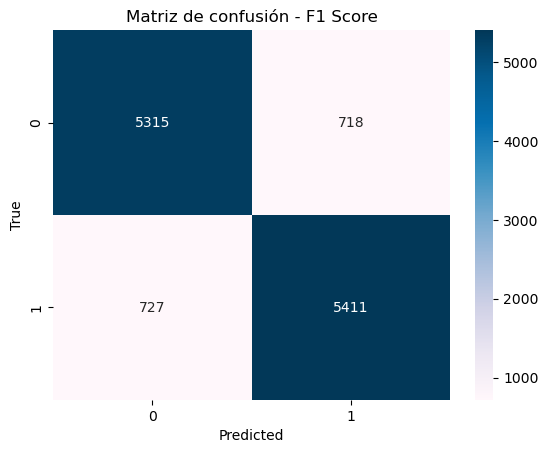

In [9]:
# Hacemos predicción sobre el set de evaluacion
y_pred = model_xgb.predict(x_test)

# Reporte y Matriz de Confusion
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='PuBu',annot=True,fmt='g')
plt.title("Matriz de confusión - F1 Score")
plt.xlabel('Predicted')
plt.ylabel('True')

Score de cada split:

In [10]:
results = cross_validate(model_xgb, x_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True)

metricsCV = results['test_score']
metricsCV

array([0.8850528 , 0.88884398, 0.87859166, 0.88670757, 0.89168357,
       0.88293772, 0.88884398, 0.88290494, 0.8866571 , 0.88399592])

#### Score de accuracy:

In [11]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc*100))

Accuracy: 88.13%


#### Gráfico del boxplot de F1 Score:

<Axes: >

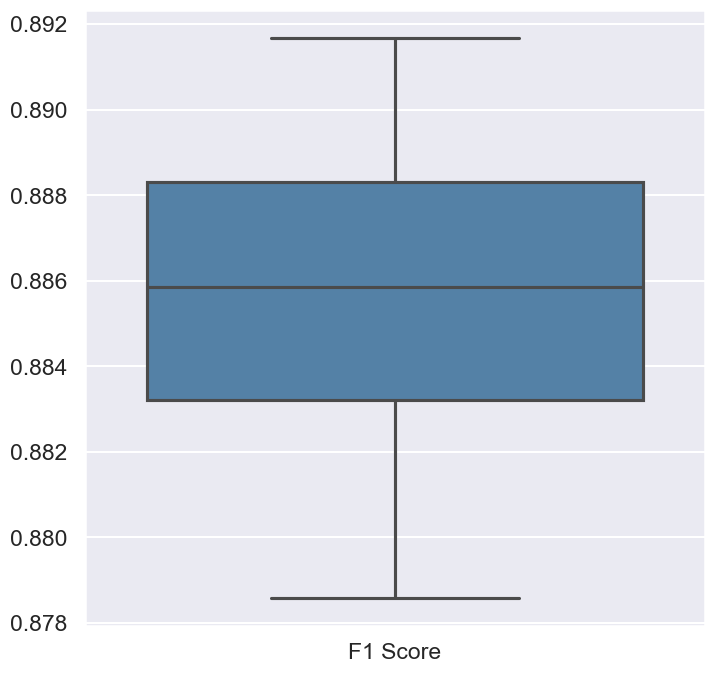

In [12]:
metric_labelsCV = ['F1 Score']*len(metricsCV)
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure(figsize=(8,8))
sns.boxplot(x=metric_labelsCV, y=metricsCV, color='steelblue')

#### Gráfico de curva ROC:

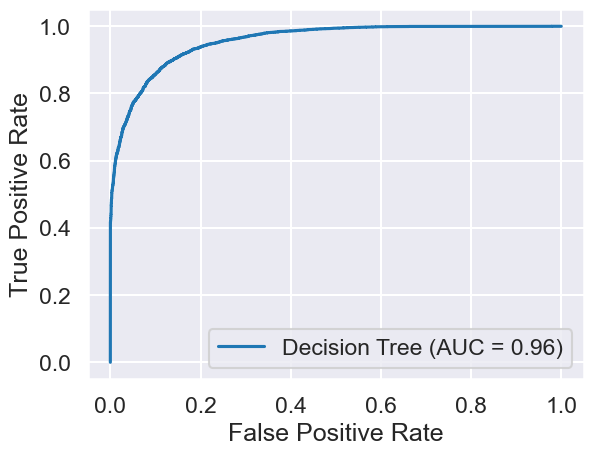

In [13]:
y_pred = model_xgb.predict_proba(x_test)[:, 1]  # obtener las probabilidades para la clase positiva
fpr, tpr, _ = roc_curve(y_test, y_pred) # FPR y TPR son acrónimos de "False Positive Rate" y "True Positive Rate"
roc_auc = roc_auc_score(y_test, y_pred)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Decision Tree').plot()
plt.legend(loc="lower right")  # agregar leyenda en la esquina inferior derecha
plt.show()

---

## Aplicación del modelo al dataset de test

##### Lectura del dataset de test preprocesado:

In [14]:
hotel_test = pd.read_csv('./dataset/hotels_test_preprocesado.csv')

##### Lectura del dataset de test original para mantener id:

In [15]:
hotel_test_df = pd.read_csv('./dataset/hotels_test.csv')

##### Predicción y exportación:

In [16]:

x_test_final = hotel_test[features]

y_pred_final = model_xgb.predict(x_test_final)


In [17]:
pd.concat([hotel_test_df['id'],pd.DataFrame(data=y_pred_final, columns=['is_canceled'])], axis=1).to_csv('./predicciones/pred_xgboost_n10_split10.csv', index=False)

---

## Exportación del modelo

In [18]:
dump(model_xgb, open('./modelos/model_xgboost_randomcv.pkl', 'wb'))

---